In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
matplotlib.rc('figure', figsize=(15, 5))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.stattools import adfuller, kpss

from os.path import isfile

import warnings
warnings.filterwarnings("ignore")

# Carpeta de salida
output_folder='./Output'

from models import *

2022-12-11 22:45:00.739224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 22:45:01.400336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-11 22:45:01.401292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-11 22:45:01.401304: W tensorflow/com

## __1. Análisis de la Serie Temporal__

In [2]:
eolic = pd.read_csv('Eolica.csv',
                    header=0, parse_dates=[0], index_col=[0], 
                    usecols=[0, 3], dayfirst=True, squeeze=True)

In [3]:
eolic.isna().any()

True

Observamos que efectivamente existen NA's en nuestra serie, como se puede ver en la siguiente celda:

In [4]:
num=10
print("PRIMEROS",num,"DATOS:"); print(eolic.head(num))
print("ÚLTIMOS",num,"DATOS:"); print(eolic.tail(num))

PRIMEROS 10 DATOS:
Date
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
2016-01-06    278101.80
2016-01-07    247007.30
2016-01-08          NaN
2016-01-09          NaN
2016-01-10          NaN
Name: WindEnergy, dtype: float64
ÚLTIMOS 10 DATOS:
Date
2018-12-22    95918.79
2018-12-23    43276.21
2018-12-24    13585.14
2018-12-25    18349.89
2018-12-26    21548.11
2018-12-27    10872.37
2018-12-28    18077.52
2018-12-29    85855.44
2018-12-30    63911.85
2018-12-31    31660.28
Name: WindEnergy, dtype: float64


Ante esta situación se deberá de interpolar los datos para hacer la que la serie sea continua. En nuestro caso lo hemos hecho con el método "spline" que realiza una interpolación basada en polinomios cuadráticos para completar los valores NA y suavizar de la mejor manera posible la serie.

In [5]:
eolic = eolic.interpolate(method='spline', order=2)
print("PRIMEROS",num,"DATOS:"); print(eolic.head(num))

PRIMEROS 10 DATOS:
Date
2016-01-01    280606.590000
2016-01-02    181981.120000
2016-01-03    329470.870000
2016-01-04    216707.380000
2016-01-05    204859.990000
2016-01-06    278101.800000
2016-01-07    247007.300000
2016-01-08    230107.631979
2016-01-09    252847.756622
2016-01-10    254171.380252
Name: WindEnergy, dtype: float64


In [6]:
eolic = eolic/(17560*24)
eolic

Date
2016-01-01    0.665828
2016-01-02    0.431808
2016-01-03    0.781774
2016-01-04    0.514207
2016-01-05    0.486095
                ...   
2018-12-27    0.025798
2018-12-28    0.042895
2018-12-29    0.203719
2018-12-30    0.151651
2018-12-31    0.075124
Name: WindEnergy, Length: 1096, dtype: float64

<AxesSubplot:xlabel='Date'>

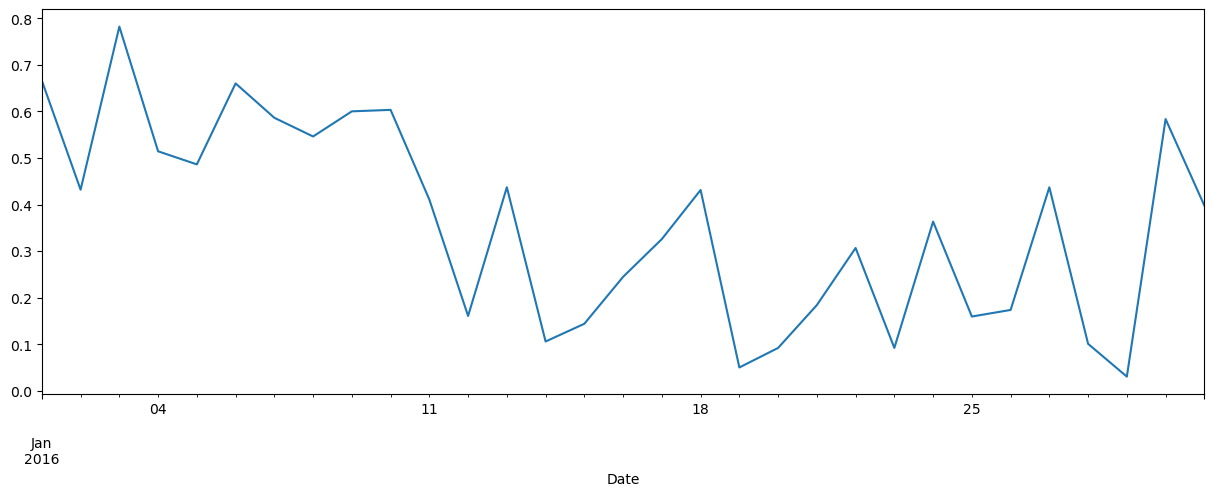

In [7]:
plt.figure();eolic['2016-01'].plot()

<AxesSubplot:xlabel='Date'>

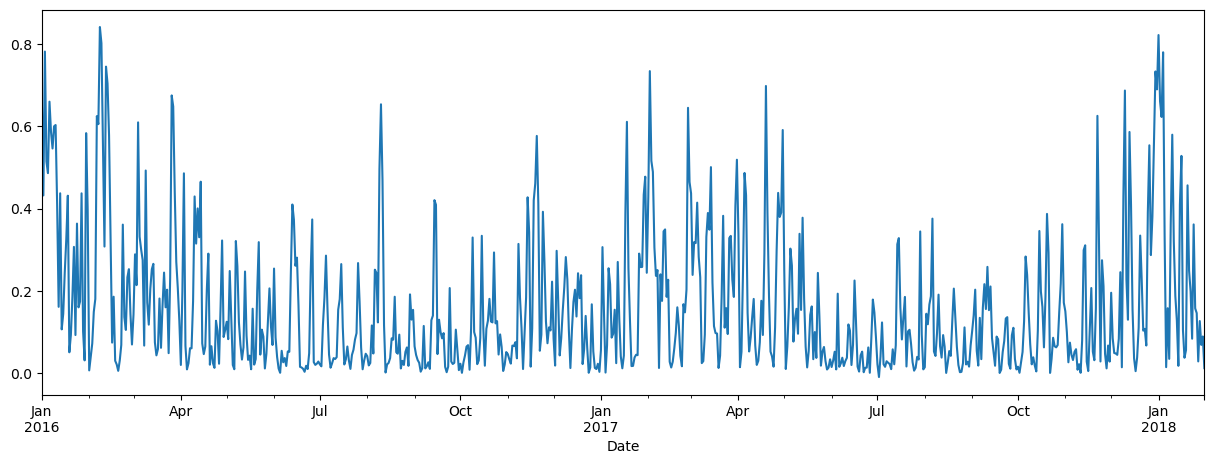

In [8]:
plt.figure();eolic['2016-01':'2018-01'].plot()

In [9]:
eolic.describe()

count    1096.000000
mean        0.163340
std         0.168134
min        -0.009911
25%         0.035543
50%         0.103886
75%         0.238356
max         0.841489
Name: WindEnergy, dtype: float64

#### __1.1 Descomposición para el análisis de tendencia y estacionalidad__

<Figure size 1500x500 with 0 Axes>

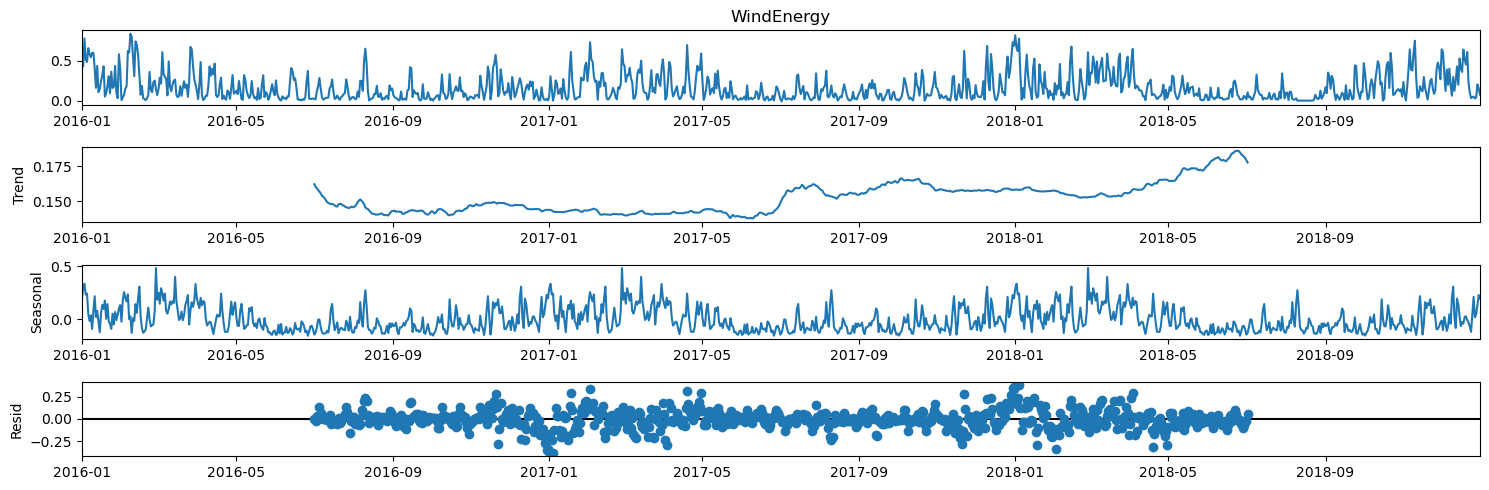

In [10]:
prd = 365
eolic_cpy = eolic['2016':'2018'].copy()
result=tsa.seasonal_decompose(eolic_cpy, model='additive', period=prd)
plt.figure();result.plot();

#### __1.2 Test ADF__


In [11]:
adf_test(eolic)

ADF Statistic: -4.162637935964149
n_lags: 0.000761707961080949
p-value: 0.000761707961080949
Critial Values:
   1%, -3.4364476591811033
Critial Values:
   5%, -2.864232347211692
Critial Values:
   10%, -2.5682035004867494
Result: The series is stationary


#### __1.3 Test KPSS__

In [12]:
kpss_test(eolic)

KPSS Statistic: 0.1952500760003884
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


#### __1.4 Análisis de ACF y PACF__

<Figure size 1500x500 with 0 Axes>

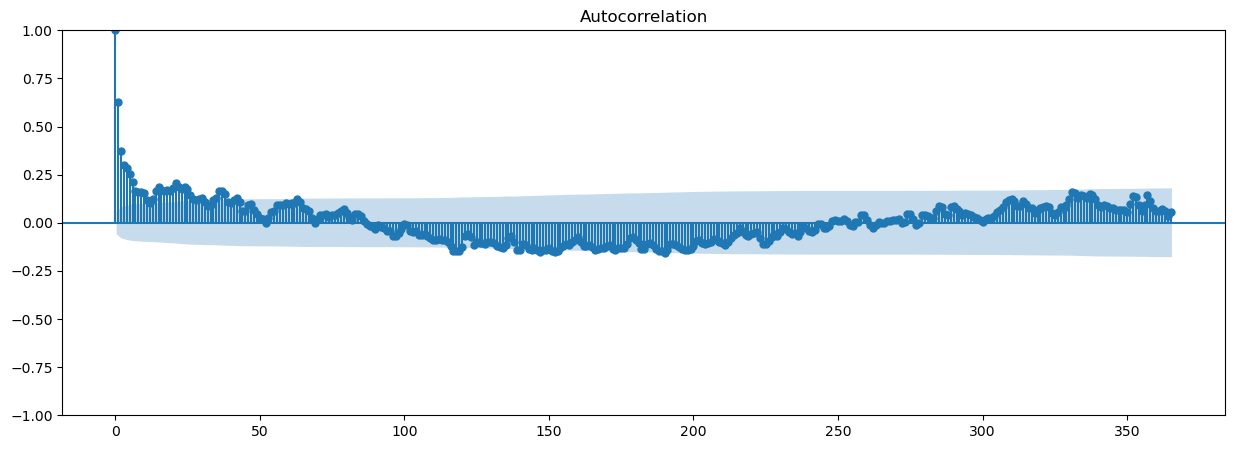

<Figure size 1500x500 with 0 Axes>

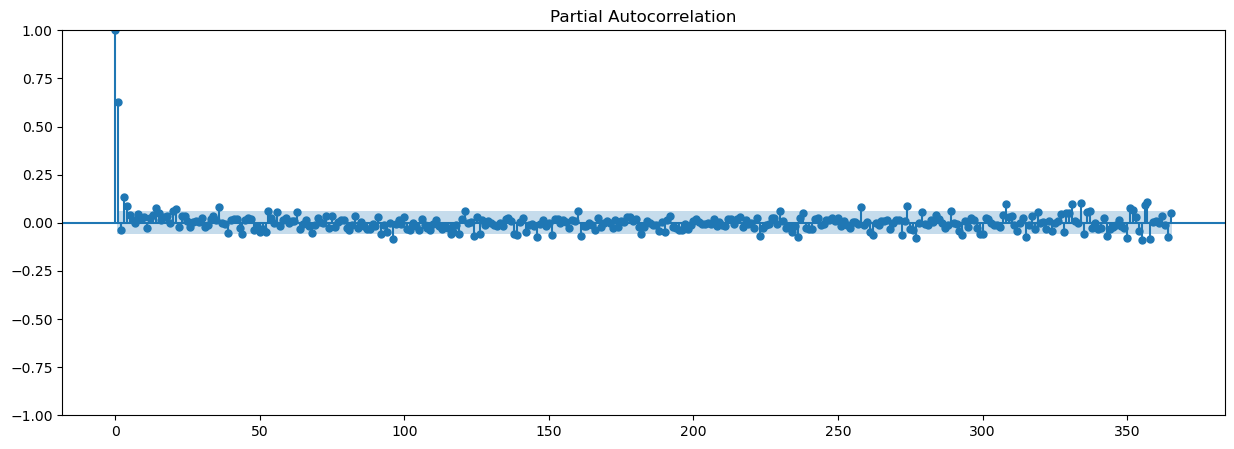

In [13]:
plt.figure(); tsaplots.plot_acf(eolic, lags=prd); plt.show()
plt.figure(); tsaplots.plot_pacf(eolic, lags=prd); plt.show()

#### __Método Box-Jenkins__

Una vez que hemos graficado las gráficas de autocorrelación y de correlación parcial, podemos identificar cual de los modelos de la familia ARMA es el que mas nos conviene. El método Box-Jenkins asume que si el proceso es estacionario, este se puede aproximar por ARMA. Este consta de 3 pasos cada vez que se reciben nuevos datos:

1. __Identificación__: Elegir un submodelo que defina los datos, esto se puede ver en la siguiente tabla:

|      | MA(q)                                                  | AR(p)                                                      | ARMA(p,q)                                                   |
|------|--------------------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| ACF  | Primeros q coefs significativos.  Caída brusca a 0     | Decrecimiento exponencial  rápido u ondas sinusoidales     | Crecimiento irregular, con q picos. Decaimiento  posterior. |
| PACF | Decrecimiento  exponencial rápido u ondas sinusoidales | Primeros p coeficientes  significativos. Caída brusca a 0. | Decrece paulatinamente.                                     |

Como se puede observar en la tabla previa, en el caso de ACF tenemos un decrecimiento exponencial rápido para acabar teniendo ondas sinusoidales no significativas (ya que están por debajo de la banda). En el caso de PACF vemos que el primer lag (p=1) es significativo pero luego hay una caída brusca a 0.

Estas características corresponden a un modelo __AR(1)__.

2. __Estimación__: Búsqueda de coeficientes. Del cual se encargará el propio modelo elegido, ya que la función SARIMAX de la librería statsmodels realiza un ajuste iterativo de minimización (mínimos cuadrados, BFGS...).

3. __Comprobación__: Ver si el modelo se adecúa a los datos. Los errores residuales del modelo deben continuar siguiendo una normal (Gaussianos e independientes). 

## __2. Predicciones en la Serie Temporal__

In [14]:
s_tr = eolic['2016']
s_va = eolic['2017']
s_te = eolic['2018']

n_tr = len(s_tr)
n_va = len(s_va)
n_te = len(s_te)

#### __2.1 Modelo AR(1)__

In [15]:
#DEFINICIÓN DEL MODELO
p = 1
q = 0

mod = SARIMAX_train(eolic, (p, 0, q), n_tr+n_va, period=prd)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67526D-01    |proj g|=  6.79890D-02

At iterate    5    f= -1.67667D-01    |proj g|=  1.58071D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   2.738D-06  -1.677D-01
  F = -0.16767088721009615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


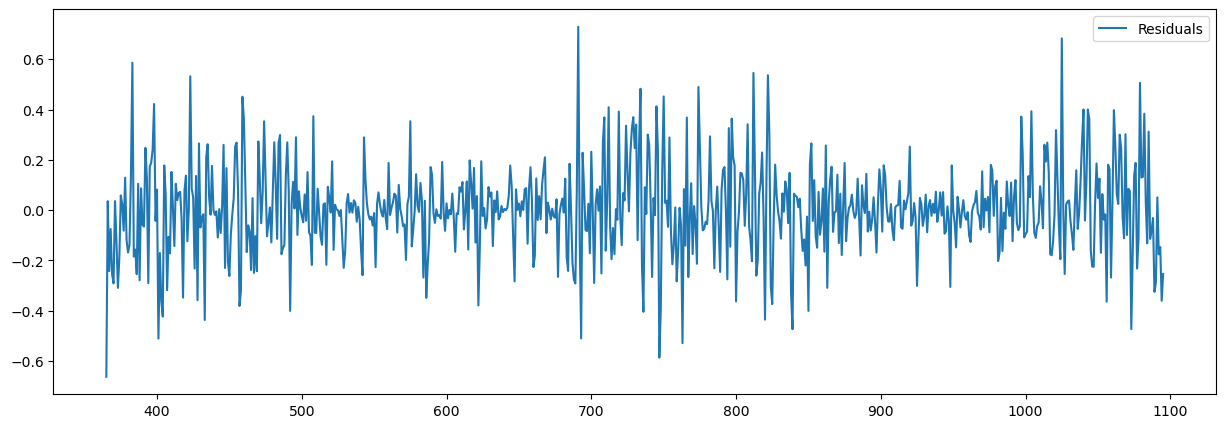

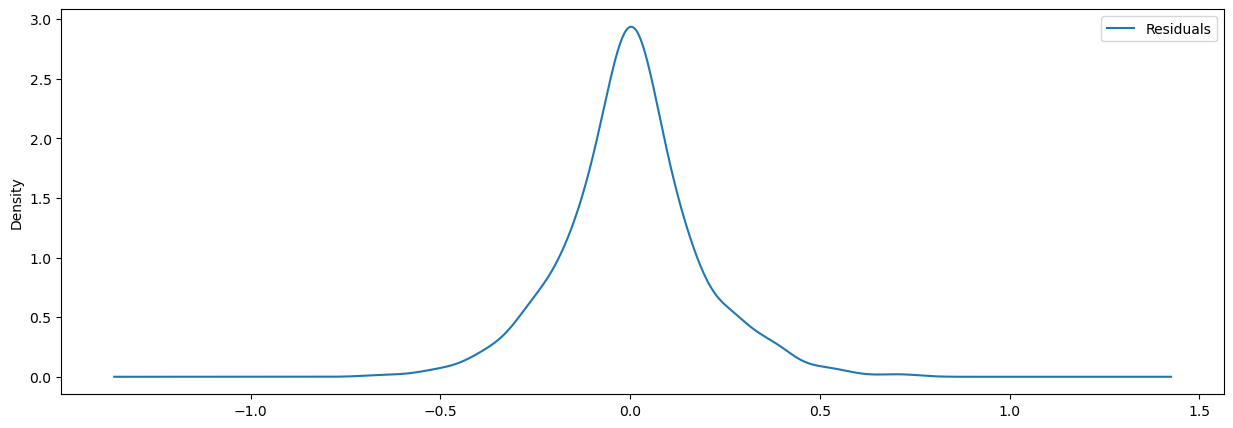

In [16]:
residuals = pd.DataFrame(mod.resid, columns=['Residuals'])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()

Se puede observar efectivamente que los residuos del modelo siguen una normal.

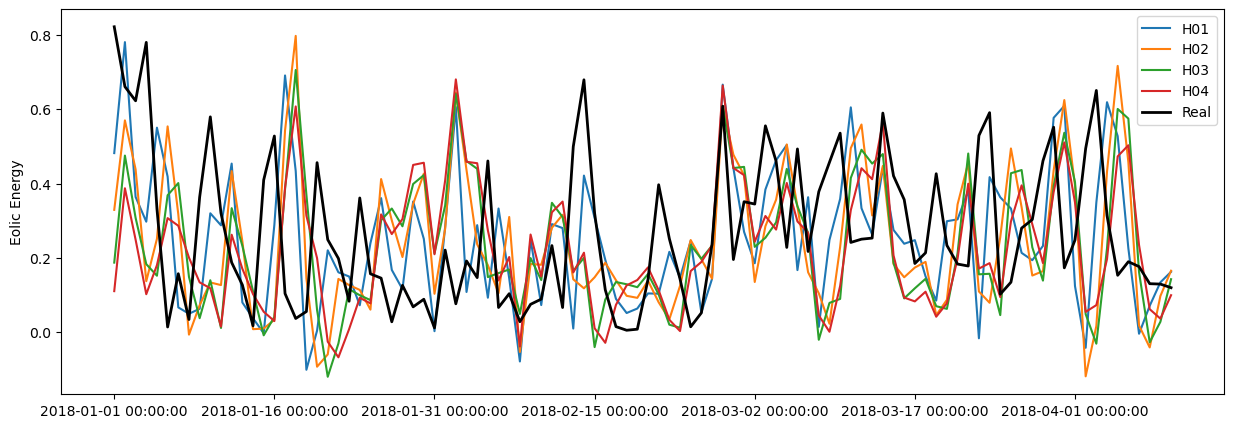

In [17]:
n_horizon=4

start=n_tr + n_va
end=n_tr + n_va + n_te

preds_ar1 = []

for h in range(n_horizon):
    current_pred = SARIMAX_predict(mod, eolic, start, end, h, 
                               period=prd)
    preds_ar1.append(current_pred)
    plt.plot(current_pred[0:100], label='H%02d' % (h + 1))
    
y = eolic[start:start+100]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=15)
plt.xticks(xticks, x[xticks])
plt.ylabel("Eolic Energy")
plt.legend()
plt.show()

Como se puede observar en la gráfica de arriba, lo cierto es que las predicciones que realiza el modelo no son muy acertadas. Veamos el MAE (_mean absolut error_) para ver que errores refleja nuestra serie.

In [18]:
n_horizon=4
maes_h = []
for h in range(n_horizon):
    maes = errors_by_day(eolic[start:end], preds_ar1[h], MAE=True)
    maes_h.append(maes)

In [19]:
n_horizon = 4
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))

MAE Total H01: 0.13
MAE Total H02: 0.16
MAE Total H03: 0.17
MAE Total H04: 0.17


Vemos que el modelo AR(1) no funciona como lo esperado ya que sus predicciones no son las mas precisas. Vamos a ver si realizando una validación iterando sobre distintos valores de p, obtenemos un mejor resultado.

#### Uso de validate para extraer los mejores hiperparámetros

In [ ]:
best_order = validate(0, eolic, n_tr, n_va - n_horizon, period=prd)
print(best_order)

Donde se obtiene como mejor valor (p,d,q) los valores **(0,0,4)** que va en contra con la información sacáda del análisis del método Box-Jenkins. Probemos por tanto con esta hiperparámetría que tal se comporta nuestro modelo.

#### __2.2 Modelo BEST ORDER ARMA(0, 4)__  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71660D-01    |proj g|=  1.16239D-01

At iterate    5    f= -1.72624D-01    |proj g|=  2.53477D-03

At iterate   10    f= -1.72638D-01    |proj g|=  8.08766D-03

At iterate   15    f= -1.72640D-01    |proj g|=  1.69203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   2.201D-05  -1.726D-01
  F = -0.17264004477367390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


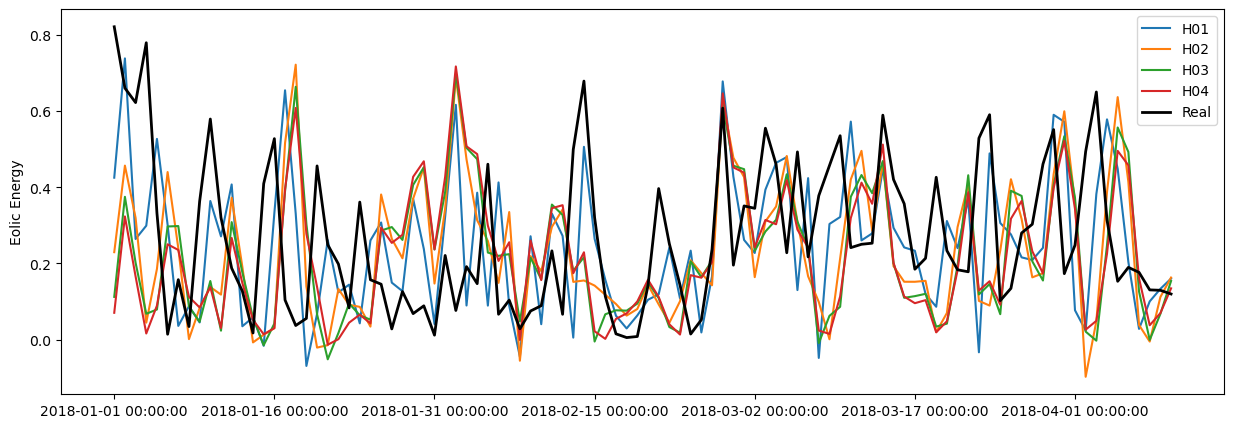

In [21]:
n_horizon=4

start=n_tr + n_va
end=n_tr + n_va + n_te

mod = SARIMAX_train(eolic, best_order, n_tr+n_va, period=prd)

preds_ar1 = []

for h in range(n_horizon):
    current_pred = SARIMAX_predict(mod, eolic, start, end, h, 
                               period=prd)
    preds_ar1.append(current_pred)
    plt.plot(current_pred[0:100], label='H%02d' % (h + 1))
    
y = eolic[start:start+100]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=15)
plt.xticks(xticks, x[xticks])
plt.ylabel("Eolic Energy")
plt.legend()
plt.show()

In [22]:

maes_h = []
for h in range(n_horizon):
    maes = errors_by_day(eolic[start:end], preds_ar1[h], MAE=True)
    maes_h.append(maes)

maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))

MAE Total H01: 0.13
MAE Total H02: 0.16
MAE Total H03: 0.17
MAE Total H04: 0.17


Como hemos mencionado previamente, esta hiperparametría iba en el sentido opuesto a la deducida observando las gráficas de ACF y PACF. De hecho el MAE de estas predicciones nos indica que es algo peor que AR(1) por lo que seleccionaremos como nuestros mejores parámetros (1,0,0) para las siguientes evoluciones del modelo. Cabe destacar que el resto de los modelos de la familia SARIMA no serán necesarios de estudiar, ya que estos se han de tener en cuenta en caso de que nuestra serie temporal tenga tendencia y estacionalidad.

#### __2.3 Modelo ARX(1)__

En este caso, haremos uso de variables exógenas. Para ello nos serviremos de ambas variables restantes (pese a que si se realiza la correlación entre la Energía del Viento y la dirección se ve un coeficiente del 5%, muy bajo, con respecto a la velocidad que da casi un 85%). Prepararemos de nuevo los datos para entrenar nuestro modelo. Incluiremos las variables exógenas en nuestra función "train" y veremos si existe alguna mejora en la predicción.

In [23]:
eolic = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 1, 2, 3], dayfirst=True, squeeze=True)
eolic.head(20)

,WindSpeed,WindDirection,WindEnergy
Date,,,
2016-01-01,12.96,190.0,280606.59
2016-01-02,10.68,217.0,181981.12
2016-01-03,16.69,223.0,329470.87
2016-01-04,11.35,250.0,216707.38
2016-01-05,12.72,261.0,204859.99
2016-01-06,14.62,222.0,278101.80
2016-01-07,16.03,233.0,247007.30
2016-01-08,NaN,NaN,NaN
2016-01-09,NaN,NaN,NaN


In [24]:
eolic.isna().any()
eolic = eolic.interpolate(method='spline', order=2)

eolic['WindEnergy'] = eolic['WindEnergy']/(17560*24)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80876D-01    |proj g|=  2.21996D+01

At iterate    5    f= -1.93813D-01    |proj g|=  5.18652D-01

At iterate   10    f= -1.93825D-01    |proj g|=  6.71858D-01

At iterate   15    f= -1.94008D-01    |proj g|=  2.34852D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     42      1     0     0   7.918D-01  -1.940D-01
  F = -0.19402082365278556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
	Computi

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


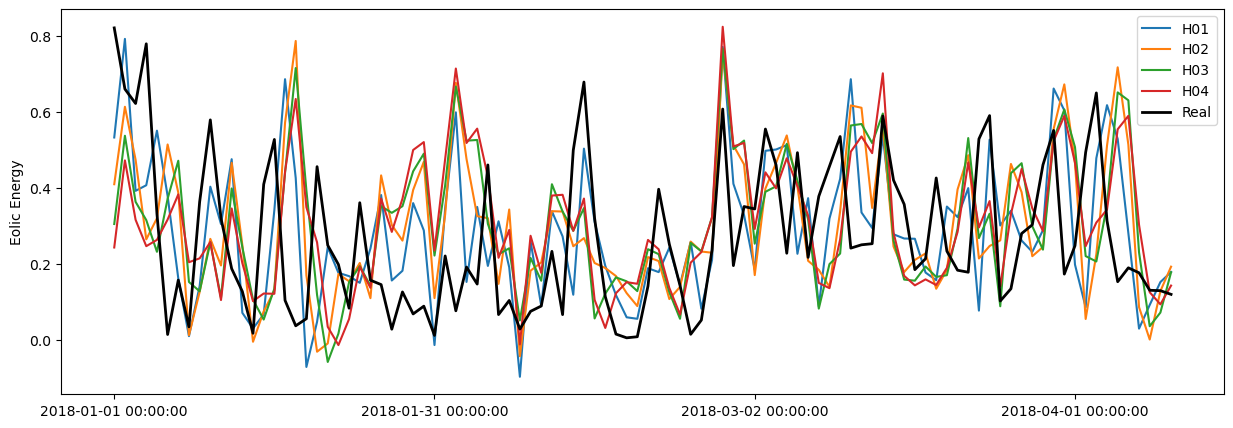

In [25]:
#Reutilizamos los valores d elos mejores hiperparámetros obtenidos hasta el momento
p=1
d=0
q=0

mod_arx1 = SARIMAX_train(eolic.loc[:,'WindEnergy'], (p, d, q), n_tr + n_va, period=prd, exog=eolic[['WindSpeed', 'WindDirection']])
maes_h = []
preds_arx1 = []
for h in range(n_horizon):
    current_pred = SARIMAX_predict(mod_arx1, eolic.loc[:,'WindEnergy'], start, end, h, prd)
    preds_arx1.append(current_pred)
    plt.plot(current_pred[0:100], label='H%02d' % (h + 1))
    maes = errors_by_day(eolic.loc[:, 'WindEnergy'][start:end], preds_arx1[h], MAE=True)
    maes_h.append(maes)

y = eolic.loc[:, 'WindEnergy'][start:start+100]
x = y.index
plt.plot(y.to_numpy(), 'k', linewidth=2, label='Real')
xticks = np.arange(len(y), step=30)
plt.xticks(xticks, x[xticks])
plt.ylabel("Eolic Energy")
plt.legend()
plt.show()

In [26]:
maes_t = np.array(maes_h)[:, 0]
maes = np.array(maes_h)[:, 1:]
for h in range(n_horizon):
    print('MAE Total H%02d: %.2f' % (h + 1, maes_t[h]))

MAE Total H01: 0.12
MAE Total H02: 0.15
MAE Total H03: 0.16
MAE Total H04: 0.16


Vemos que existe una ligerísima mejora, pero esta no es suficiente para poder confiar en las predicciones de nuestro modelo. Es claro como, para este problema, los modelos clásicos no son buenos y realizan predicciones no muy cercanas a la realidad. Pasaremos por tanto a probar con modelos mas actuales que comprenden la complejidad intrínseca de los datos y que creemos que darán un mejor resultado.

### __2.4 LSTM__

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.utils import set_random_seed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### __Preprocesamiento de los datos__

In [28]:
eolic = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 1, 2, 3], dayfirst=True, squeeze=True)
eolic = eolic.interpolate(method='spline', order=2)

eolic['WindEnergy'] = eolic['WindEnergy']/(17560*24)
eolic.head(20)

,WindSpeed,WindDirection,WindEnergy
Date,,,
2016-01-01,12.960000,190.000000,0.665828
2016-01-02,10.680000,217.000000,0.431808
2016-01-03,16.690000,223.000000,0.781774
2016-01-04,11.350000,250.000000,0.514207
2016-01-05,12.720000,261.000000,0.486095
2016-01-06,14.620000,222.000000,0.659885
2016-01-07,16.030000,233.000000,0.586103
2016-01-08,17.538742,1122.750281,0.546003
2016-01-09,17.013321,1420.826016,0.599961


En el caso de la entrada a la red, después de hacer pruebas con varios intervalos de días (desde 5 hasta 21), vemos que el mejor valor que se ha alcanzado, es 7 (una semana). Dado que en previos modelos, las variables exógenas han dado una pequeña ventaja sobre el modelo univariante, las utilizaremos también para resolver estos problemas. Para ello contaremos con que, por cada día el modelo contará con 3 datos, y dado que hemos aclarado que la cantidad de días óptima para hacer la predicción es 7, nuestra entrada tendrá un total de 7x3 entradas.

La arquitectura de nuestra red tendrá una entrada de 7x3, seguida de dos bloques de capas retroalimentadas de 128 neuronas del tipo LSTM con DropOut. El DropOut sirve para que las neuronas entre las capas no dependan específicamente de unas conexiones en particular, si no que estas ganen "independencia" y así no tiendan al overfitting (dado que, si siempre los mismos caminos se activan, los resultados serán siempre los mismo, no generalizandon y adaptándose a la variabilidad de los datos).

In [29]:
PATH = "./tmp/BestModel/"

set_random_seed(123)
model = Sequential()
model.add(LSTM(128, activation="tanh", recurrent_activation = "sigmoid", input_shape=(7, 3), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation="tanh", recurrent_activation = "sigmoid", return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation="tanh", return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate = 0.001), metrics=["mean_absolute_error"])

'''
model = Sequential()
model.add(LSTM(50, input_shape=(7, 3)))
model.add(Dropout(0.5, input_shape=(1,)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

'''


2022-12-11 22:45:47.442239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-11 22:45:47.463856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-11 22:45:47.464187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-11 22:45:47.464605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

'\nmodel = Sequential()\nmodel.add(LSTM(50, input_shape=(7, 3)))\nmodel.add(Dropout(0.5, input_shape=(1,)))\nmodel.add(Dense(1))\nmodel.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])\n\n'

Cabe a destacar también la habilitación que tiene tensorflow del entrenamiento mediante GPUs, instalando la librería CUDNN que sirve de interfaz entre la librería CUDA de NVIDIA y Tensorflow, se hace uso de los núcleos CUDA y tensores incorporados en la gráfica, dando así unos mejores resultados y unos tiempos de entrenamiento mucho mas bajos que si se entrenase solo con CPU.

Epoch 1/200


2022-12-11 22:45:52.520788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2022-12-11 22:45:52.657734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


22/22 [==============================] - 4s 23ms/step - loss: 0.0288 - mean_absolute_error: 0.1214
Epoch 2/200
22/22 [==============================] - 0s 22ms/step - loss: 0.0095 - mean_absolute_error: 0.0739
Epoch 3/200
22/22 [==============================] - 0s 20ms/step - loss: 0.0215 - mean_absolute_error: 0.1014
Epoch 4/200
22/22 [==============================] - 0s 21ms/step - loss: 0.0159 - mean_absolute_error: 0.0950
Epoch 5/200
22/22 [==============================] - 1s 24ms/step - loss: 0.0083 - mean_absolute_error: 0.0672
Epoch 6/200
22/22 [==============================] - 0s 21ms/step - loss: 0.0121 - mean_absolute_error: 0.0790
Epoch 7/200
22/22 [==============================] - 0s 21ms/step - loss: 0.0087 - mean_absolute_error: 0.0714
Epoch 8/200
22/22 [==============================] - 0s 21ms/step - loss: 0.0121 - mean_absolute_error: 0.0782
Epoch 9/200
22/22 [==============================] - 0s 21ms/step - loss: 0.0091 - mean_absolute_error: 0.0739
Epoch 10/200


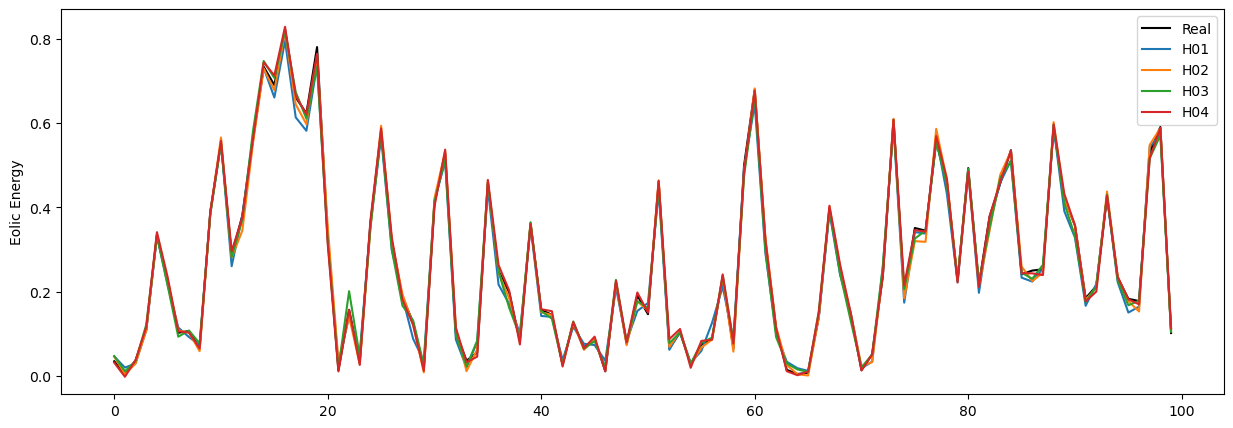

In [30]:
mae_lstm=[]
epochs=[200, 200, 100, 100]

for h in range(4):

    bst_model_path = PATH + "best_weights" + str(h) + ".h5"
    callbacks = [
        EarlyStopping(monitor="mean_absolute_error", patience=50),
        ModelCheckpoint(filepath = bst_model_path, save_best_only=True, save_weights_only=True, monitor="mean_absolute_error")
    ]

    dataset_tr, dataset_te, y_te = create_dataset(eolic, n_tr, n_va, h=h, batch_size=32)
    history_rnn = model.fit(dataset_tr, epochs=epochs[h], verbose=1, callbacks=callbacks)

    model.load_weights(bst_model_path)
    preds_rnn = model.predict(dataset_te, verbose=0)

    if (h == 0):
        plt.plot(y_te[10:110], "k", label='Real')
    plt.plot(preds_rnn[10-h:110-h], label='H%02d' % (h+1))
    mae_lstm.append(mean_absolute_error(y_te, preds_rnn))

plt.ylabel("Eolic Energy")
plt.legend()
plt.show()

MAE Total H01: 0.01
MAE Total H02: 0.01
MAE Total H03: 0.01
MAE Total H04: 0.01


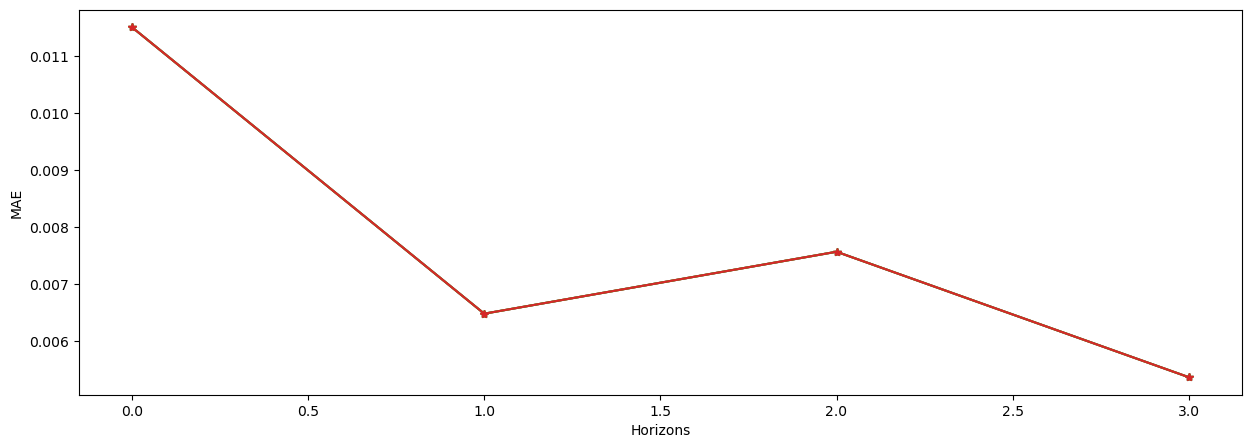

In [31]:
for h in range(4):
    plt.plot(mae_lstm, '*-')
    print('MAE Total H%02d: %.2f' % (h + 1, mae_lstm[h]))
plt.xlabel("Horizons")
plt.ylabel("MAE")
plt.show()

Viendo la gráfica de predicciones, se aprecia que las LSTMs son la mejor solución para "resolver" este problema. Dando los MAEs mas bajos y siendo capaces de ajustar muy bien al conjunto de test.